In [1]:
import os
from utils.data_directory_manager import DataDirectoryManager
from utils.img_diff import OutputAnalysis
from utils.rasterize import rasterize_label, save_raster
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np

In [2]:
base_dir = "/home/dsa/DSA/images_manual"
dm = DataDirectoryManager(base_dir)
test_scene_id = "LC82201072015017LGN00"
rock_shape = "/home/dsa/DSA/vectors/Landsat_8_Derived_Outcrop_Dataset_2016.shp"
rasterize_base = os.path.join(dm.corrected_image_dir, test_scene_id, test_scene_id + "full_color_seg.tif")
actual_path = os.path.join(dm.corrected_image_dir, test_scene_id, test_scene_id + "_burjo_output.tif")
expected_path = os.path.join(dm.corrected_image_dir, "rasterized_rock_shape.tif")
diff_path = os.path.join(dm.corrected_image_dir, "test_diff.tiff")
assert os.path.exists(actual_path)
assert os.path.exists(rasterize_base)

In [3]:

with rio.open(actual_path) as output_tif:
    actual = output_tif.read(1)
print(actual.dtype)


uint16


In [4]:
expected = rasterize_label(rasterize_base, rock_shape)

In [5]:
save_raster(expected[0], expected[1], expected_path)

In [6]:
differ = OutputAnalysis(expected[0], actual)

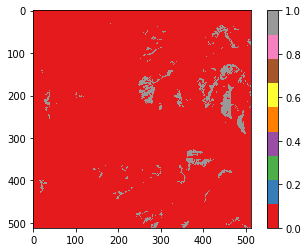

In [7]:
differ.create_fig(expected[0])

In [8]:
save_raster(differ.diff_raster, expected[1], diff_path)

Total: 262144
Agreement: 261113
Disagreement:1031
Negative: 251118
False Negative: 764
False Positive: 267
Positive:9995

Accuracy: 99.61%
Error: 0.39%
Omission Error
	Rock: 7.10%
	NotRock: 0.11%
Commission Error
	Rock: 2.60%
	Notrock: 0.11%

Producer's Accuracy
	Rock: 92.90%
	Not Rock: 99.89%
User's Accuracy
	Rock:97.40%
	Not Rock: 99.70%




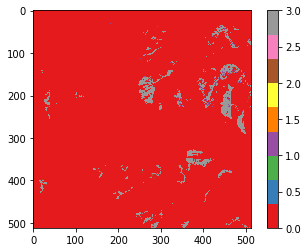

In [9]:
differ.create_fig(differ.diff_raster)
print(differ)

<BarContainer object of 4 artists>

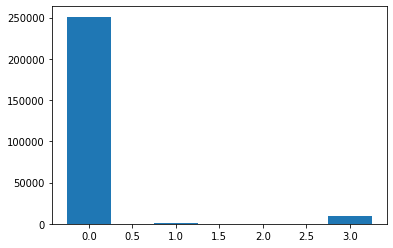

In [10]:
fig, ax = plt.subplots()
ax.bar(np.arange(4), differ.diff_hist, width=.5)